# 1. Preparar Ambiente de Trabajo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')

In [2]:
# obtenemos la lista de archivos en la carpeta dump
file_list = glob.glob('./../../data/un2_dump/*.csv')
append_csv = []
for f in file_list:
    append_csv.append(pd.read_csv(f, index_col=None, header=0).drop(columns='Unnamed: 0'))
df_lyrics = pd.concat(append_csv)
df_lyrics.columns = ['Artist', 'Genre', 'Song', 'Lyrics']

In [3]:
append_csv[9]

,0,1,2,3
0,De La Soul,hiphop,Jenifa Taught Me (Derwin's Revenge),DOVE: \n Access to her code \n Lovestruck was ...
1,De La Soul,hiphop,Potholes In My Lawn,"(Yo, something's wrong here. No, not again!) \..."
2,De La Soul,hiphop,The Magic Number,POS \n 3 \n That's the Magic Number \n Yes it ...
3,De La Soul,hiphop,Change In Speak,POS: \n Once again it's time to bite more soul...
4,De La Soul,hiphop,Cool Breeze On The Rocks,Cool breeze \n Rock that shit homie \n Rock \n...
...,...,...,...,...
169,De La Soul,hiphop,Stakes Is High (Remix),*Trugoy:* \n (Vibes... Vibrations...) \n Yeah....
170,De La Soul,hiphop,Stix Stonz,"Chorus: all \n If you can dig it, deal with it..."
171,De La Soul,hiphop,Weed #1 - Pharoahe Monch,"(Announcer) \n Hey hip-hoppers, tired of that ..."
172,De La Soul,hiphop,Weed #2 - Phife Dawg,(Announcer) \n Still not convinced about Ghost...


# 2. Descripción de Datos

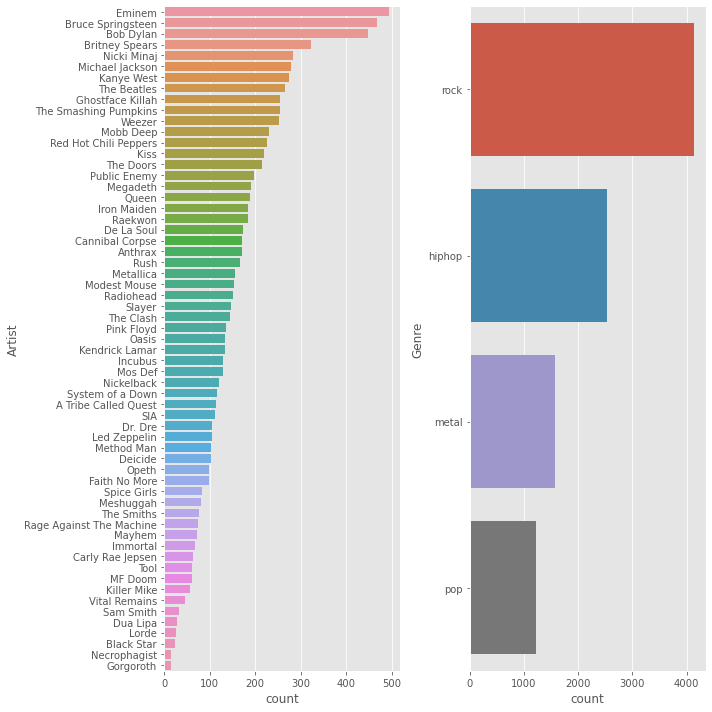

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
sns.countplot(y=df_lyrics['Artist'], order = df_lyrics['Artist'].value_counts().index)
plt.tight_layout()

plt.subplot(1, 2,2)
sns.countplot(y=df_lyrics['Genre'], order = df_lyrics['Genre'].value_counts().index)
plt.tight_layout()

# 3. Matriz de Ocurrencias

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer=CountVectorizer(stop_words='english')
count_vectorizer_fit = count_vectorizer.fit_transform(df_lyrics.Lyrics)
words = count_vectorizer.get_feature_names()
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

In [7]:
#d = count_vectorizer_fit.toarray()
d#.shape

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [8]:
words_freq_df = pd.DataFrame([list(words), list(words_freq)]).T

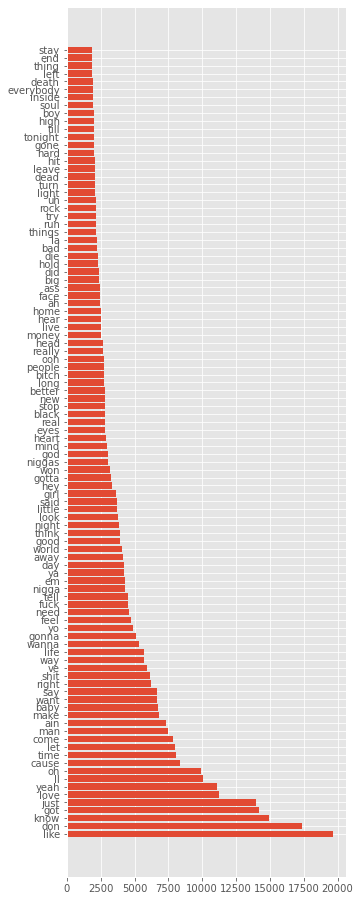

In [9]:
words_freq_df.columns= ['words', 'freq']
words_freq_df = words_freq_df.sort_values(by='freq', ascending=False).iloc[0:100, :]

plt.figure(figsize=(5, 16))
plt.barh(words_freq_df['words'], words_freq_df['freq']);
# plt.xticks(rotation=45);

In [5]:
def word_count_by_genre(vectorizer=CountVectorizer(stop_words='english', ngram_range=(1, 2)),
                        df=df_lyrics, target='Lyrics', genre='hiphop', sort_n=100):
    """TODO: Docstring for word_count_by_genre.
    :df: TODO
    :genre: TODO
    :returns: TODO
    """
    tmp_vect = vectorizer
    tmp_fit_transform = tmp_vect.fit_transform(df[df['Genre'] == genre][target])
    tmp_words = tmp_vect.get_feature_names()
    tmp_frequencies = tmp_fit_transform.toarray().sum(axis=0)
    tmp_df = pd.DataFrame([ list(tmp_words), list(tmp_frequencies) ]).T
    tmp_df.columns = ['words', 'freq']
    tmp_df = tmp_df.sort_values(by='freq', ascending=False).iloc[0:sort_n, :]
    plt.barh(tmp_df['words'],tmp_df['freq']);

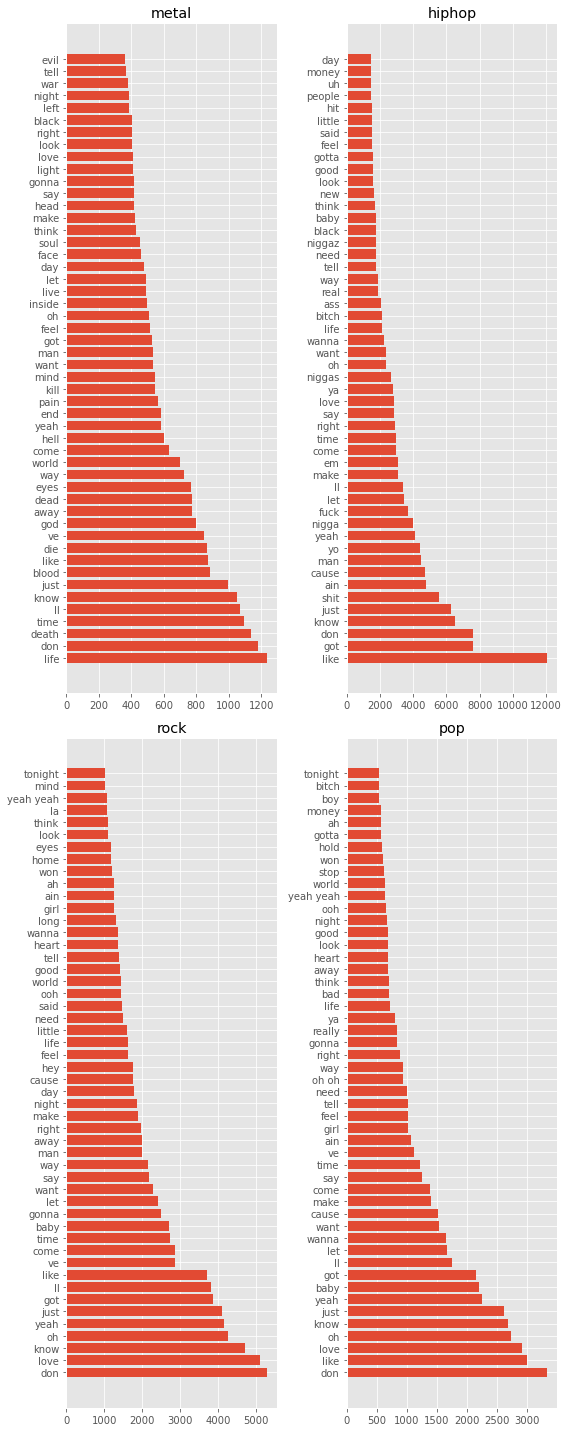

In [6]:
plt.figure(figsize=(8, 20))
for index, gen in enumerate(df_lyrics['Genre'].unique()):
    plt.subplot(2, 2, index + 1)
    word_count_by_genre(genre=gen, sort_n=50)
    plt.title(gen)
    plt.tight_layout()

# 4. Entrenamiento del Modelo

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(df_lyrics['Lyrics'], df_lyrics['Genre'], test_size=.33, random_state=11238)

text_clf = Pipeline( [('vect', CountVectorizer(stop_words='english')),
                      ('clf', MultinomialNB(alpha=0.1))])

text_clf.fit(X_train, y_train)
yhat = text_clf.predict(X_test)
confusion_matrix(y_test,yhat)

array([[ 768,    3,   17,   32],
       [  17,  401,    8,   96],
       [  42,    9,  209,  158],
       [  80,   81,  100, 1111]], dtype=int64)

In [9]:
(pd.crosstab(y_test,yhat, normalize=True)*100).round(1)

col_0,hiphop,metal,pop,rock
Genre,,,,
hiphop,24.5,0.1,0.5,1.0
metal,0.5,12.8,0.3,3.1
pop,1.3,0.3,6.7,5.0
rock,2.6,2.6,3.2,35.5


In [12]:
text_clf.predict(['I got a place in the underworld', # Brody Dalle - Underworld 
                  'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
                  "Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
                  'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris - Move B*tch 
                  "Sexual violence doesn't start and end with rape It starts in our books and behind our school gates", # IDLES - Mother,
                  "Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving" #Banks -Drowning 
                 ])

array(['rock', 'metal', 'rock', 'pop', 'metal', 'rock'], dtype='<U6')

In [36]:
yhat = text_clf.predict(X_test)
confusion_matrix(y_test, yhat)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

      hiphop       0.85      0.92      0.89       820
       metal       0.80      0.76      0.78       522
         pop       0.57      0.56      0.57       418
        rock       0.81      0.78      0.79      1372

    accuracy                           0.79      3132
   macro avg       0.76      0.76      0.76      3132
weighted avg       0.79      0.79      0.79      3132



# 5. Mejora el Modelo

In [14]:
append_csv = []

file_list = glob.glob('./../../data/un2_dump_plus_pop/*.csv')
for file in file_list:
    append_csv.append(pd.read_csv(file, index_col=None, header=0).drop(columns='Unnamed: 0'))
df_lyrics = pd.concat(append_csv)
df_lyrics.columns = ['Artist', 'Genre', 'Song', 'Lyrics']
df_lyrics.index = pd.RangeIndex(len(df_lyrics.index))
X_train, X_test, y_train, y_test = train_test_split(df_lyrics['Lyrics'], df_lyrics['Genre'], test_size=.33, random_state=11238)

# define our model
text_clf = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', MultinomialNB())])

text_clf.fit(X_train, y_train)
yhat = text_clf.predict(X_test)
confusion_matrix(y_test,yhat)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

      hiphop       0.86      0.88      0.87       874
       metal       0.84      0.67      0.75       496
         pop       0.66      0.74      0.70       851
        rock       0.77      0.76      0.76      1345

    accuracy                           0.77      3566
   macro avg       0.78      0.76      0.77      3566
weighted avg       0.78      0.77      0.77      3566

